In [140]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [141]:
original = cv.imread("data/C0383713713R_full.jpg")
image = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
# image = cv.resize(image, (500, 500))
image = image[:680, :] # crop out the black parts. (for this example image)

## Chunking the image, then applying houghlines

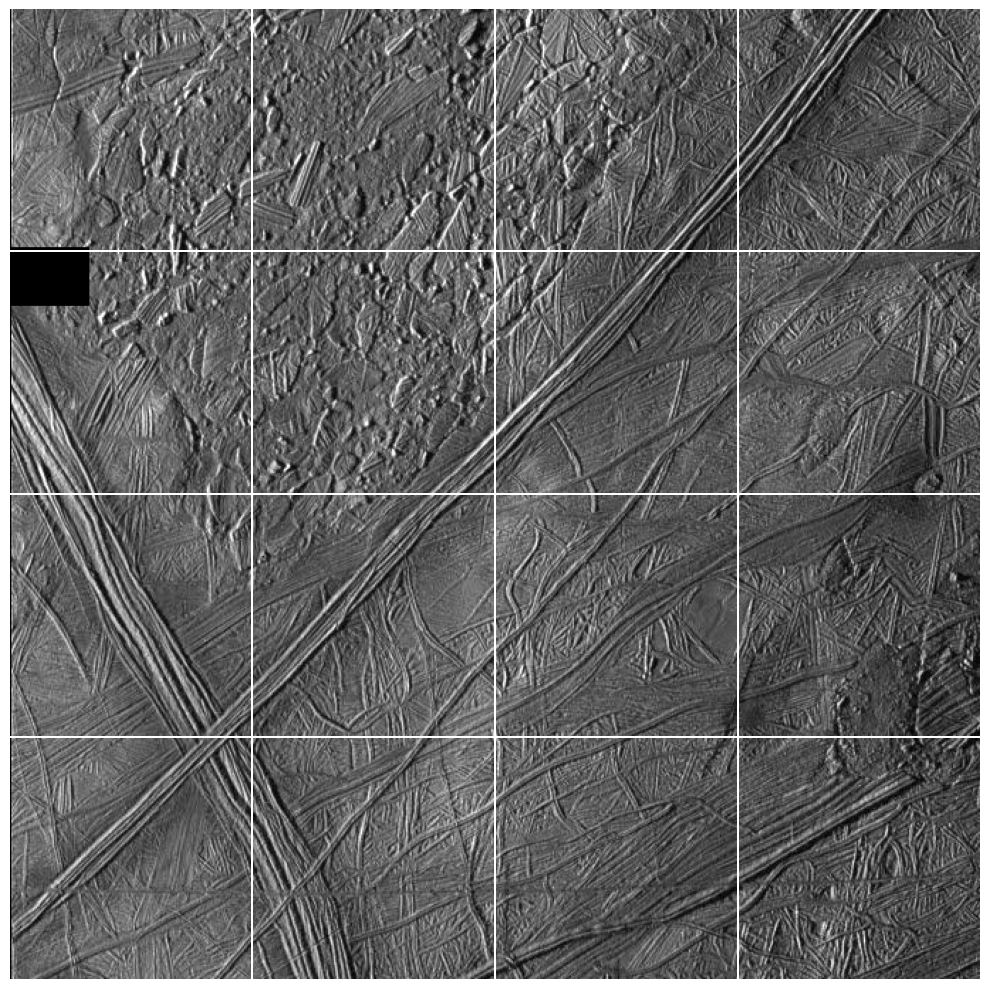

In [142]:
frames = []
chunks = 4
chunkSize = image.shape[0] // chunks
for i in range(chunks):
    row = []
    for j in range(chunks):
        row.append(image[chunkSize*i:chunkSize*(i+1), chunkSize*j:chunkSize*(j+1)])
    frames.append(row)

def plotAllFrames(frames):
    plt.figure(figsize=(10, 10))
    for i in range(chunks):
        for j in range(chunks):
            plt.subplot(chunks, chunks, i*chunks+j+1)
            plt.imshow(frames[i][j], cmap='gray')
            plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()
plotAllFrames(frames)

## Helper Functions

In [143]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))

	return cv.Canny(image, lower, upper)

def houghP(processed_img, output=None):
    if output is None:
        output = processed_img.copy()
    lines = cv.HoughLinesP(processed_img, 1, np.pi/90, 80, minLineLength=40, maxLineGap=10)
    output = output.copy()
    if lines is None:
        return output
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(output, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return output

def hough(processed_img, output=None):
    if output is None:
        output = processed_img.copy()
    lines = cv.HoughLines(processed_img, 1, np.pi/90, 50)
    output = output.copy()
    if lines is None:
        return output
    for r_theta in lines[:10]:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr[0], arr[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + chunkSize*(-b))
        y1 = int(y0 + chunkSize*(a))
        x2 = int(x0 - chunkSize*(-b))
        y2 = int(y0 - chunkSize*(a))
        cv.line(output, (x1, y1), (x2, y2), (255), 2)
    return output
    

def plotBoth(image, title='Processed Image', original=original, original_title='Original Image'):
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(121)
    plt.imshow(cv.cvtColor(original, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(original_title)

    # Plot resized image
    plt.subplot(122)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    # Set the background of the plot to be transparent
    plt.gcf().patch.set_alpha(0)
    plt.show()


## Testing Houghlines Functions

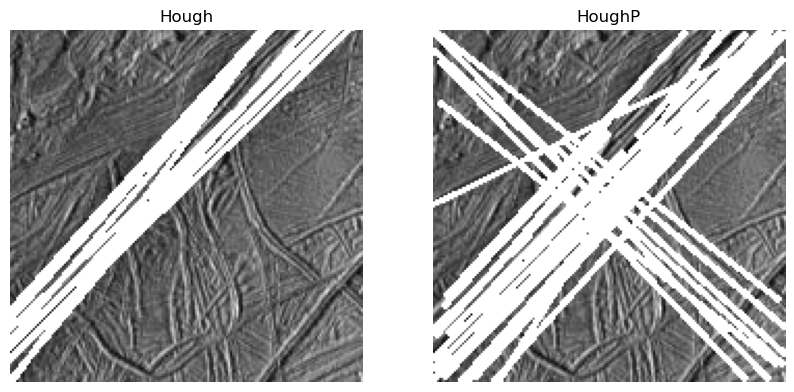

In [144]:
test_frame = frames[2][1]
canny = auto_canny(test_frame)
houghP_test = houghP(canny, test_frame)
hough_test = hough(canny, test_frame)
plotBoth(houghP_test, 'HoughP', hough_test, 'Hough')

## Preprocessing steps

In [145]:
def preprocess_canny(frame):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    frame = cv.GaussianBlur(frame, (7, 7), 0)
    frame = auto_canny(frame)
    # frame = cv.dilate(frame, None, iterations=1)
    # frame = cv.erode(frame, None, iterations=1)
    return frame
def preprocess_thresh(frame):
    _, thresh = cv.threshold(frame, 0, 255, cv.THRESH_OTSU)
    return thresh
def vectorize_frames(func):
    return np.vectorize(func, signature='(m, n)->(m, n)')

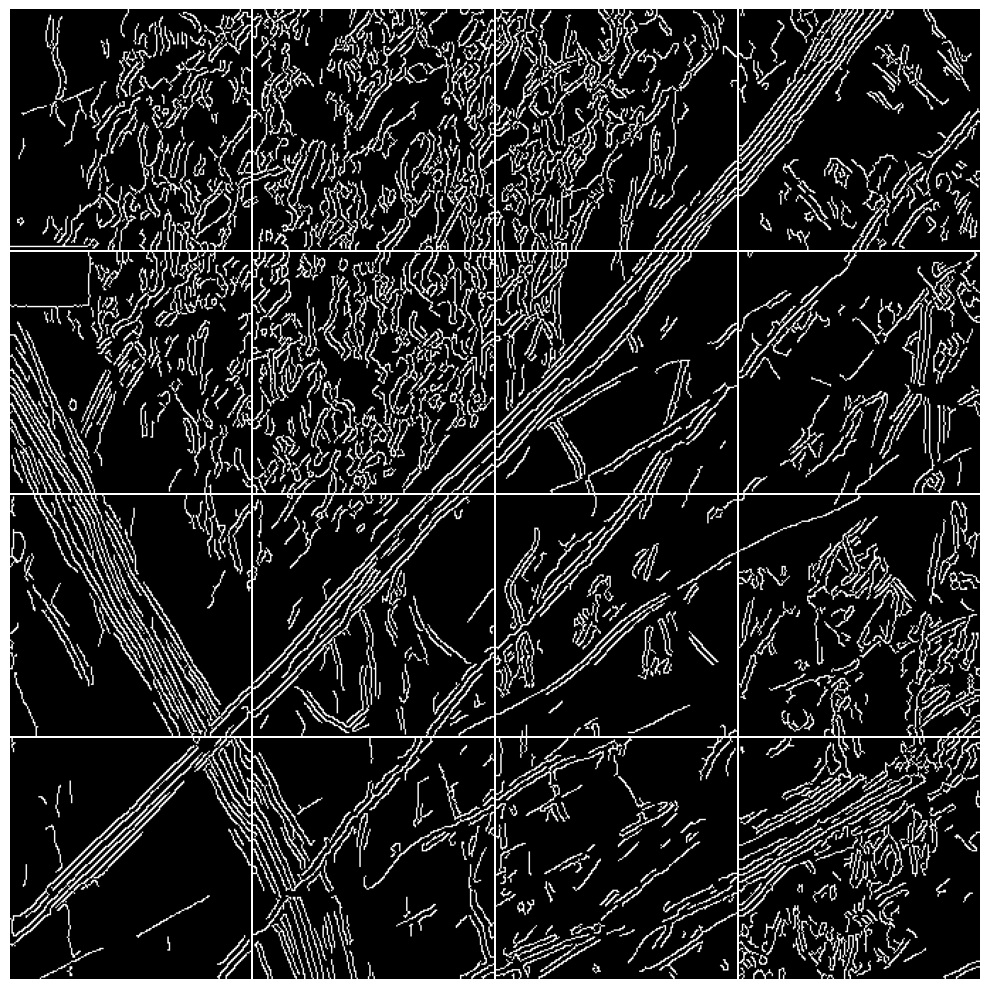

In [146]:
output_frames = vectorize_frames(preprocess_canny)(frames)
plotAllFrames(output_frames)

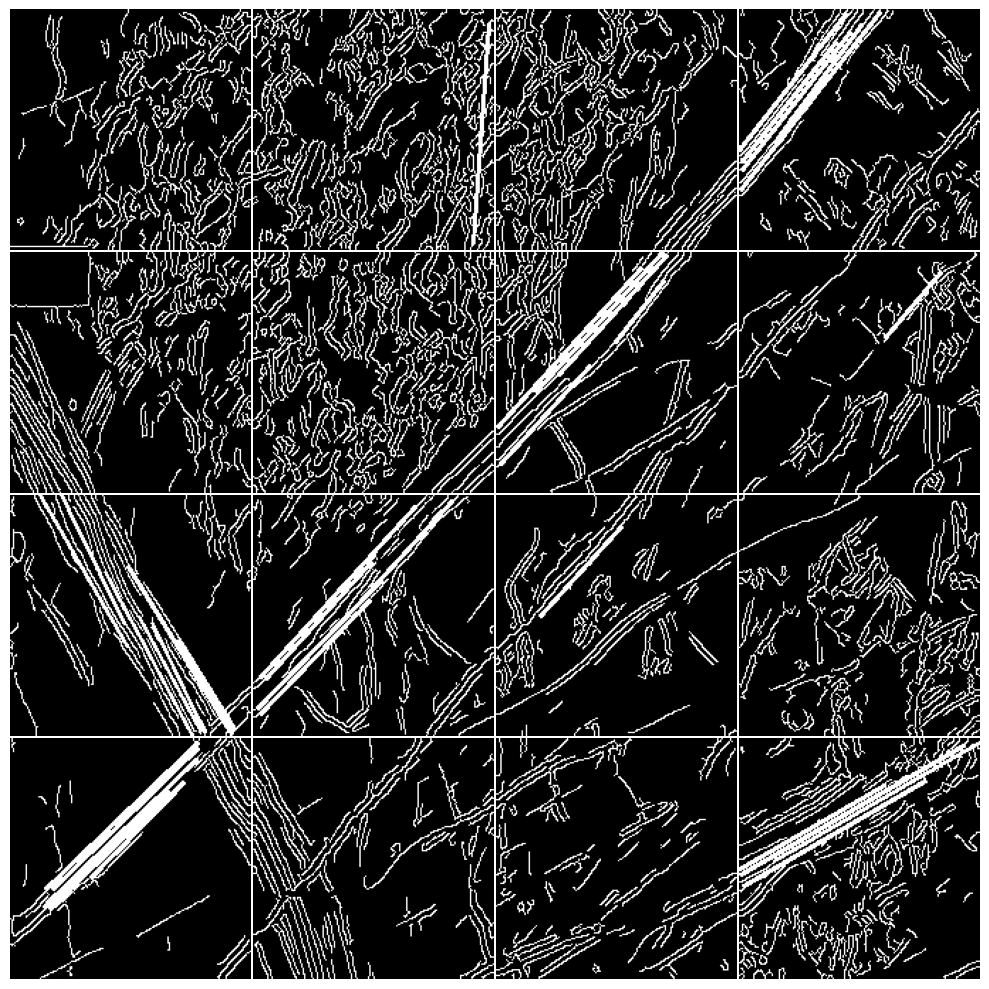

In [147]:
output_frames = vectorize_frames(houghP)(output_frames)
plotAllFrames(output_frames)

(170, 200)


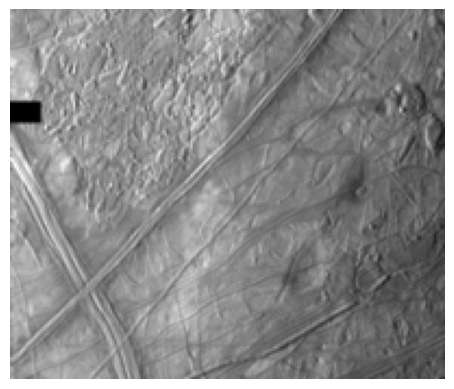

In [148]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))

pyr = cv.pyrDown(image)
pyr = cv.pyrDown(pyr)
plt.imshow(pyr, cmap='grey')
plt.axis('off')
plt.gcf().patch.set_alpha(0)
print(pyr.shape)

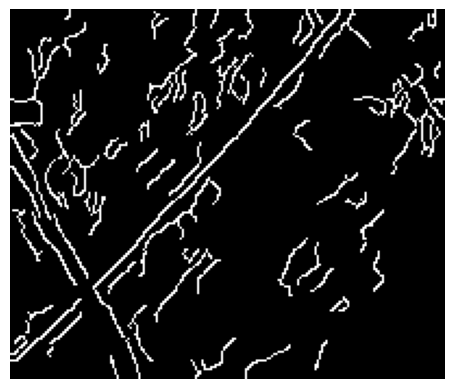

In [149]:
pyrCanny = preprocess_canny(clahe.apply(pyr))
plt.imshow(pyrCanny, cmap='grey')
plt.axis('off')
plt.gcf().patch.set_alpha(0)